In [1]:
import sys, os, time
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data, get_options

np.set_printoptions(linewidth=120, suppress=True)

In [704]:
media_root = '/is/ei/fleeb/workspace/media/hybrid/'
root = '../trained_nets/'
names = [n for n in os.listdir(root) if ('fhyb' in n or '1d91113' in n) and not 'test' in n]
chpt = None
for i, name in enumerate(names):
    print(i,name)

0 dspr-dropinp5-fhyb_191110-032619
1 dspr-dropin1-fhyb_191110-032704
2 dspr-dropinp1-fhyb_191110-032311
3 dspr-dropin1-fhyb-dim32_191111-092909
4 dspr-dropin1-fhyb-dim8_191111-092836
5 dspr-dropinp1-fhyb_191111-092805
6 dspr-dropinp5-fhyb_191111-092736
7 dspr-dropin1-fhyb-dim32_191112-062309
8 dspr-dropin1-fhyb-dim8_191112-062309
9 dspr-dropinp1-fhyb_191112-062309
10 dspr-dropinp5-fhyb_191112-062310


In [705]:
name = names[9] # 51
# name = 'dspr-wppp0001-bce-dstep4_191108-214937'
# name = 'dspr-wae-bce_191108-191511'
chpt = None
# chpt = 40
name

'dspr-dropinp1-fhyb_191112-062309'

In [706]:
args, (datasets, model) = train.load(os.path.join(root, name, 'checkpoint_{}.pth.tar'.format(chpt) if chpt is not None else ''), load_data=get_data, load_model=get_model,
                                    saveroot='/is/ei/fleeb/workspace/foundation/trained_nets/',
                                    dataroot='/is/ei/fleeb/workspace/local_data/',
                                    load_last=True)
model.to(args.device)
print(model)
print(model.optim)

Found 40 checkpoints. Using checkpoint_40.pth.tar
Loaded ../trained_nets/dspr-dropinp1-fhyb_191112-062309/checkpoint_40.pth.tar
Prob resampling: 0.1
BCELoss()
Using gan-wt: 0.0001
Using gen_types: {'hybrid'}
Loaded model_state from checkpoint
Dropin_WPP(
  (enc): Conv_Encoder(
    (conv): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True)
        (nonlin): PReLU(num_parameters=1)
      )
      (1): ConvLayer(
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True)
        (nonlin): PReLU(num_parameters=1)


In [707]:
'Trained on {:2.2f} M samples'.format(args.total_samples['train']/1e6)

'Trained on 29.49 M samples'

In [708]:
save_dir = os.path.join(media_root, name)
save_figs = True
if save_figs:
    util.create_dir(save_dir)

In [709]:
def show_nums(imgs, titles=None, H=None, W=None, figsize=(6,6),grdlines=False):
    if H is None or W is None:
        B = imgs.size(0)
        l = int(np.sqrt(B))
        assert l**2 == B, 'not right: {} {}'.format(l, B)
        H, W = l, l
    
    imgs = imgs.cpu().permute(0,2,3,1).squeeze().numpy()
    
    fig, axes = plt.subplots(H, W, figsize=figsize)
    
    if titles is None:
        titles = [None]*len(imgs)
    
    iH, iW = imgs.shape[1], imgs.shape[2]
    
    for ax, img, title in zip(axes.flat, imgs, titles):
        plt.sca(ax)
        plt.imshow(img)
        if grdlines:
            plt.plot([0,iW],[iH/2,iH/2],c='r',lw=.5,ls='--')
            plt.plot([iW/2,iW/2],[0,iH],c='r',lw=.5,ls='--')
            plt.xlim(0,iW)
            plt.ylim(0,iH)
        if title is not None:
            plt.xticks([])
            plt.yticks([])
            plt.title(title)
        else:
            plt.axis('off')
#     fig.tight_layout()
    return fig

In [710]:
# # args.dataset = '3dshapes'
# args.dataset = 'dsprites'

# datasets = get_data(args)

In [711]:
plt.close('all')

In [712]:
# Reseed after model init
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass

trainloader, *other = train.get_loaders(*datasets, batch_size=64, num_workers=args.num_workers,
							   shuffle=True, drop_last=False, )

traindata len=737280, trainloader len=11520
Batch size: 64 samples


In [713]:
loader = iter(trainloader)

In [714]:
batch = next(loader)
batch = util.to(batch, args.device)

In [715]:
X, Y = batch
X.shape, Y.shape

(torch.Size([64, 1, 64, 64]), torch.Size([64, 6]))

<IPython.core.display.Javascript object>


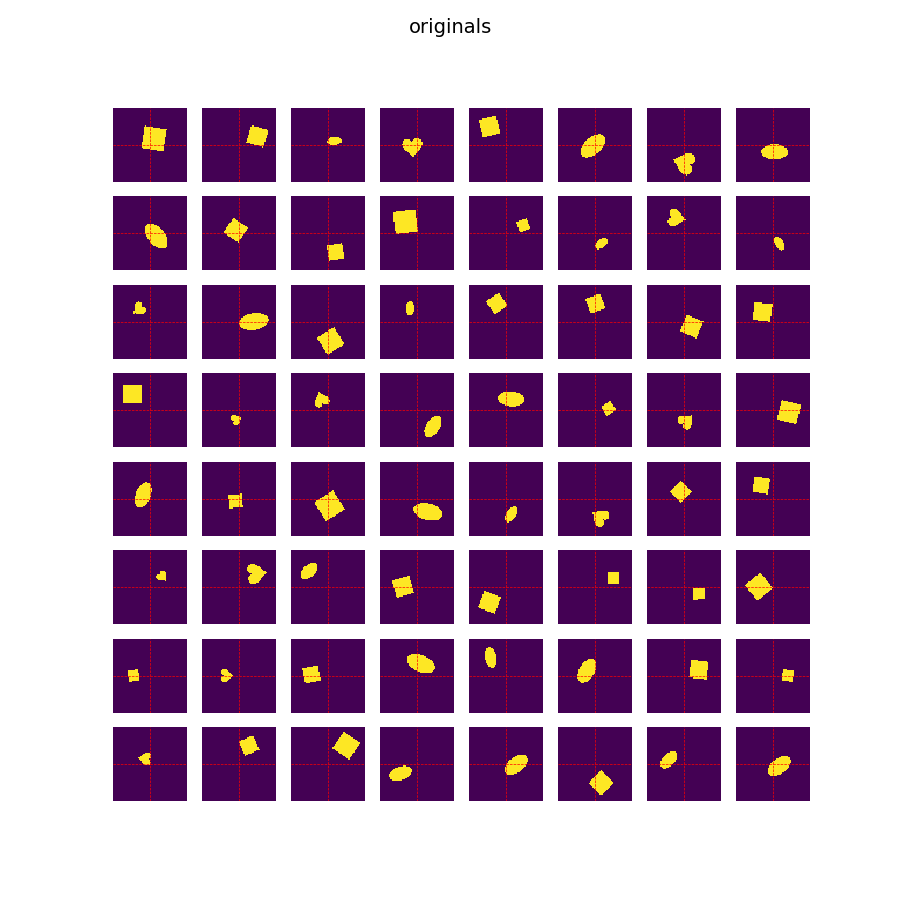

In [716]:
fig = show_nums(X, figsize=(9,9), grdlines=True)
fig.suptitle("originals", fontsize=14)
pass

In [717]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'originals.png'))

<IPython.core.display.Javascript object>


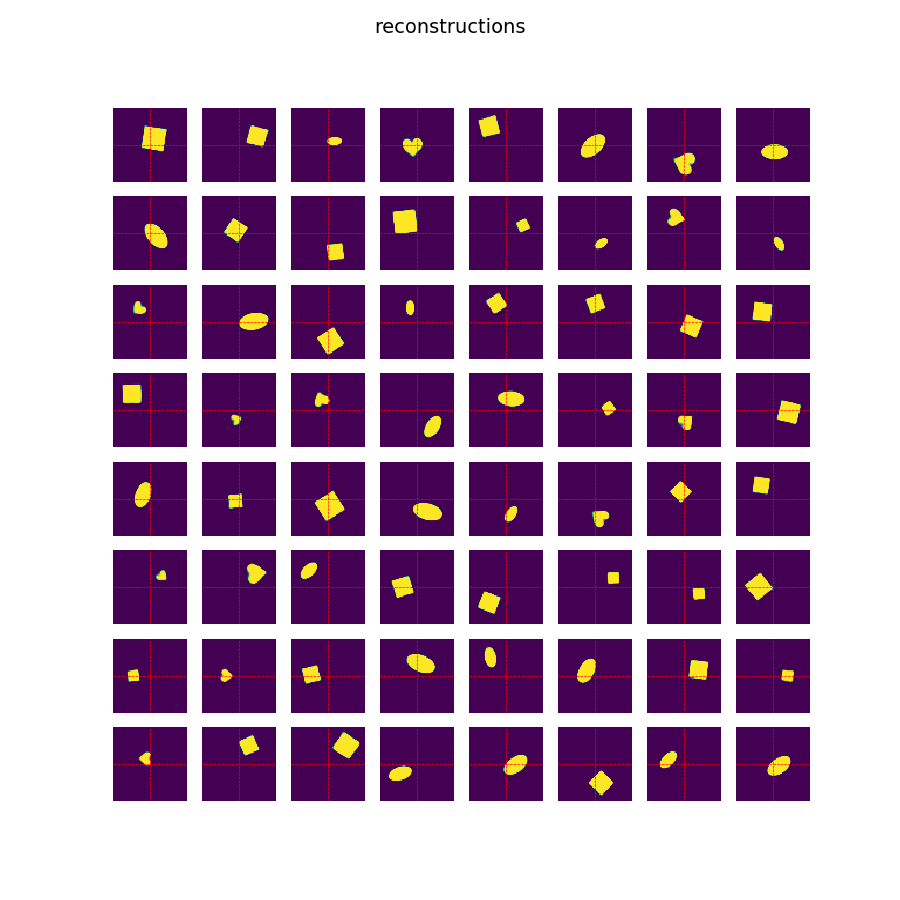

torch.Size([64, 1, 64, 64])

In [718]:
with torch.no_grad():
    
    if model.enc is None:
        q = model.sample_prior(X.size(0))
    else:
        q = model.encode(X)
    qdis = q
    qmle = q
    if isinstance(q, distrib.Distribution):
        q = q.rsample()
        qmle = qdis.loc
    rec = model.decode(q)
    vrec = model.disc(rec) if model.disc is not None else None
fig = show_nums(rec, grdlines=True,figsize=(9,9),  )#['{:4.0f}'.format(v.item()) for v in vrec])
fig.suptitle("reconstructions" if model.enc is not None else 'generated', fontsize=14)
rec.shape#, q.shape

In [719]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'recs.png' if model.enc is not None else 'gen.png'))

In [720]:
stats = qmle.min(0)[0], qmle.max(0)[0], qmle.mean(0), qmle.std(0)
stat_names = ['min', 'max', 'mean', 'std']
stats

(tensor([-1.9615, -2.4860, -2.0340, -3.3163, -2.9039, -3.3786, -2.5528, -2.7603,
         -2.4527, -3.6157, -2.3291, -2.8480, -2.0974, -3.6926, -2.0235, -2.3893],
        device='cuda:0'),
 tensor([2.1167, 3.1796, 1.9304, 2.0421, 2.3598, 1.6595, 3.3843, 3.1660, 1.9562,
         1.6496, 2.7422, 1.5940, 2.4951, 2.9839, 4.8914, 2.4523],
        device='cuda:0'),
 tensor([ 0.0985,  0.0290,  0.0986,  0.0131, -0.0226, -0.2526,  0.2017,  0.0628,
         -0.2099, -0.1643, -0.1778, -0.3731, -0.0579, -0.0592,  0.0728,  0.0077],
        device='cuda:0'),
 tensor([0.9816, 1.1742, 1.1219, 0.9973, 1.0166, 1.2186, 0.9719, 1.1428, 1.0015,
         1.1581, 0.9292, 1.0418, 1.0034, 1.1699, 1.4055, 1.0647],
        device='cuda:0'))

<IPython.core.display.Javascript object>


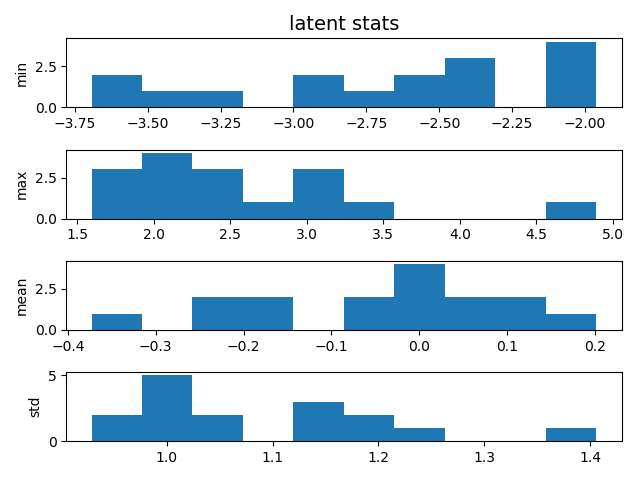

In [721]:
fig, axs = plt.subplots(4)
plt.sca(axs[0])
plt.title("latent stats", fontsize=14)
for ax, stat, sname in zip(axs, stats, stat_names):
    plt.sca(ax)
    plt.ylabel(sname)
    plt.hist(stat.cpu().numpy())
plt.tight_layout()
pass

In [722]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'stats.png'))

In [723]:
if isinstance(qdis, distrib.Distribution):
    mu, sigma = qdis.loc, qdis.scale
    stats = sigma.min(0)[0], sigma.max(0)[0], sigma.mean(0), sigma.std(0)
    
    fig, axs = plt.subplots(4)
    for ax, stat, sname in zip(axs, stats, stat_names):
        plt.sca(ax)
        plt.ylabel(sname)
        plt.hist(stat.cpu().numpy())
    fig.suptitle("scales", fontsize=14)
    plt.tight_layout()

<IPython.core.display.Javascript object>


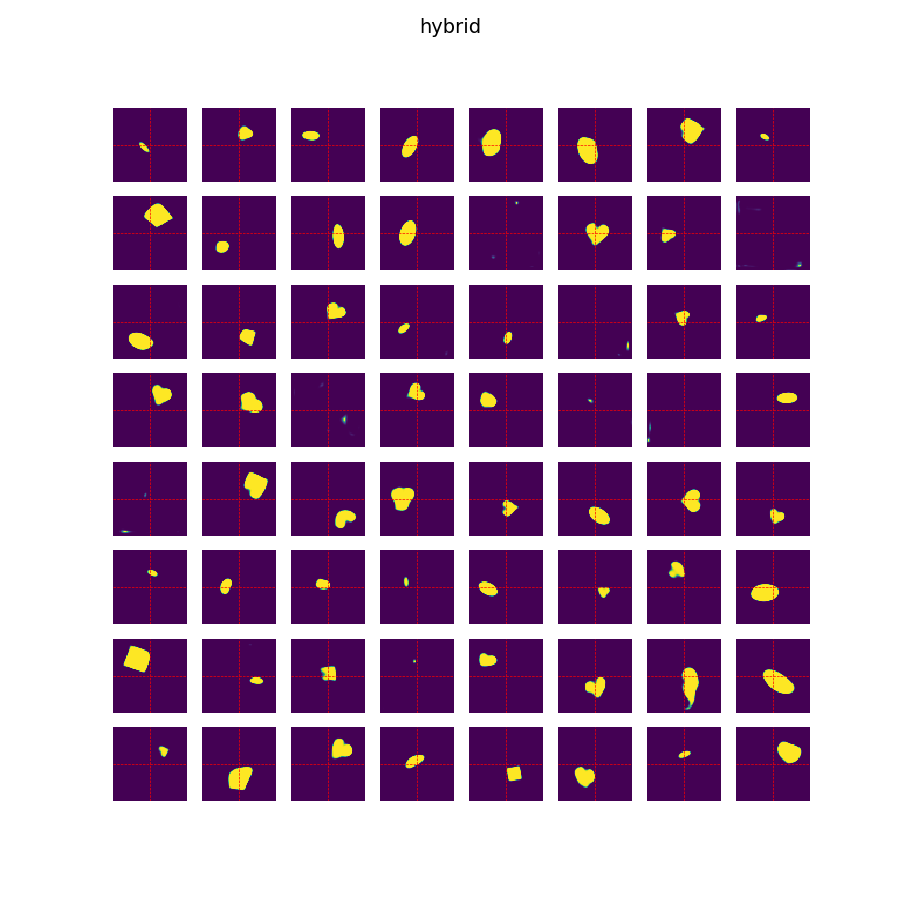

(torch.Size([64, 16]), torch.Size([64, 1, 64, 64]))

In [724]:
with torch.no_grad():
    mix = util.shuffle_dim(qdis)
#     try:
#         hyb = model.hybridize(qdis)
#     except NotImplementedError:
#         model.splits = model.latent_dim
#         hyb = Hybrid_Generator.hybridize(model, qdis)
    hygen = model.decode(mix)
    vhyb = model.disc(hygen) if model.disc is not None else None
fig = show_nums(hygen,grdlines=True, figsize=(9,9))#, ['{:4.0f}'.format(v.item()) for v in vhyb])
fig.suptitle("hybrid", fontsize=14)
mix.shape, hygen.shape

In [725]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'hybrids.png'))

<IPython.core.display.Javascript object>


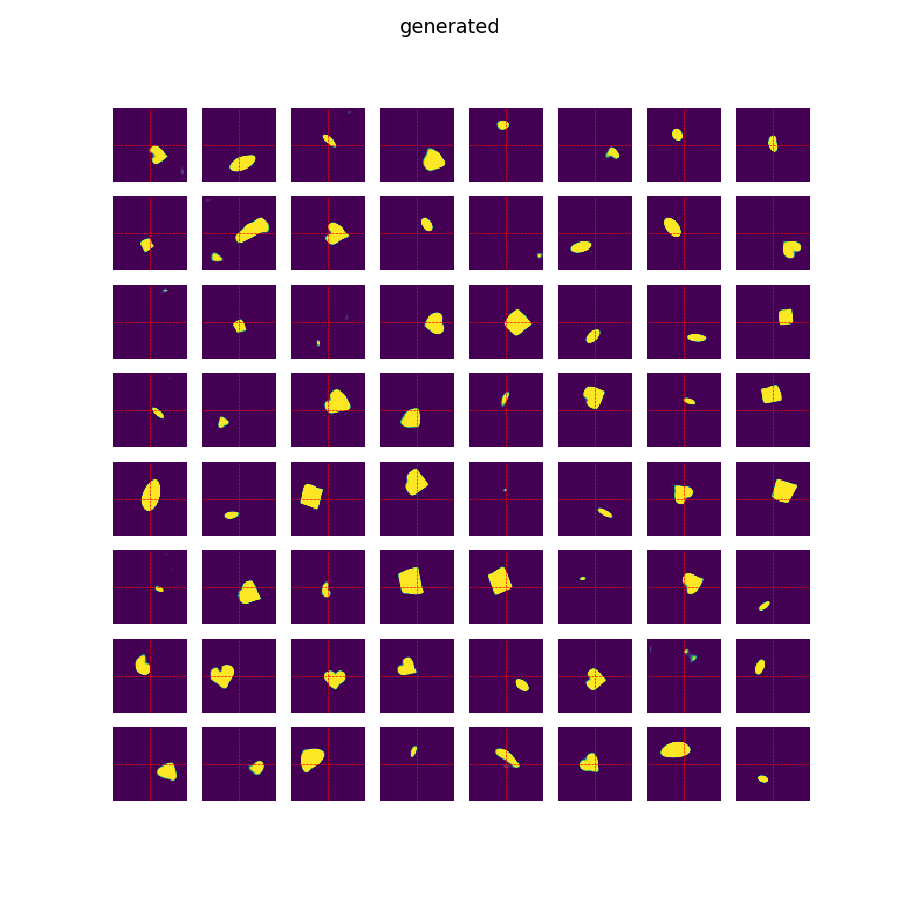

Text(0.5, 0.98, 'generated')

In [726]:
with torch.no_grad():
    gen = model.generate(X.size(0))
fig = show_nums(gen, grdlines=True,figsize=(9,9),  )#['{:4.0f}'.format(v.item()) for v in vrec])
fig.suptitle("generated", fontsize=14)

In [727]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'gen.png'))

In [692]:
# plt.close('all')

In [693]:
# # dim = 3
# idx = 1

# plt.figure()
# plt.imshow(rec[idx,0].cpu().numpy())
# plt.axis('off')
# pass

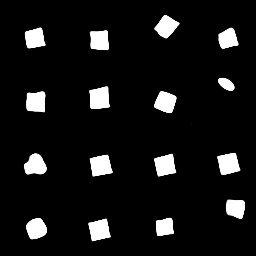

In [728]:

rows = 4
steps = 64
bounds = -2,2
# bounds = None
dlayout = rows, args.latent_dim//rows
outs = []

all_diffs = []
inds = [0, 2, 3]
inds = np.arange(len(q))
save_inds = [0, 1, 2, 3]

for idx in inds:

    walks = []
    for dim in range(args.latent_dim):

        dev = q[:,dim].std()
        if bounds is None:
            deltas = torch.linspace(q[:,dim].min(), q[:,dim].max(), steps)
        else:
            deltas = torch.linspace(bounds[0],bounds[1], steps)
        vecs = torch.stack([q[idx]]*steps)
        vecs[:,dim] = deltas

        with torch.no_grad():
            walks.append(model.decode(vecs).cpu())

    walks = torch.stack(walks,2)

    dsteps = 10
    diffs = (walks[dsteps:] * walks[:-dsteps]).abs().view(steps-dsteps, -1, 64*64).sum(-1)
    diffs = diffs / (walks[dsteps:] + walks[:-dsteps]).clamp(max=1).abs().view(steps-dsteps, -1, 64*64).sum(-1)
    diffs = 1 - diffs
#     diffs *= 2
    all_diffs.append(diffs.mean(0))

    if save_figs and idx in save_inds:
        walks_full = walks.squeeze().view(-1, dlayout[0], dlayout[1], 64, 64).permute(0,1,3,2,4).contiguous().view(-1,64*dlayout[0],64*dlayout[1])

        images = []
        for img in walks_full.cpu().numpy():
            images.append((img*255).astype(np.uint8))
        imageio.mimsave(os.path.join(save_dir, 'walks-idx{}.gif'.format(idx,dim)), images)

        with open(os.path.join(save_dir, 'walks-idx{}.gif'.format(idx,dim)),'rb') as f:
            outs.append(display.Image(data=f.read(), format='gif'))
        del walks_full
all_diffs = torch.stack(all_diffs)
outs[0]

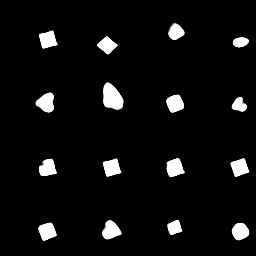

In [729]:
outs[1]

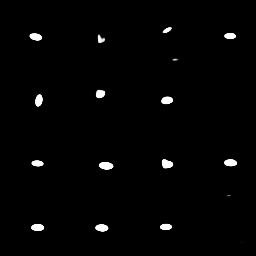

In [730]:
outs[2]

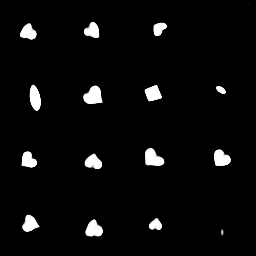

In [731]:
outs[3]

<IPython.core.display.Javascript object>


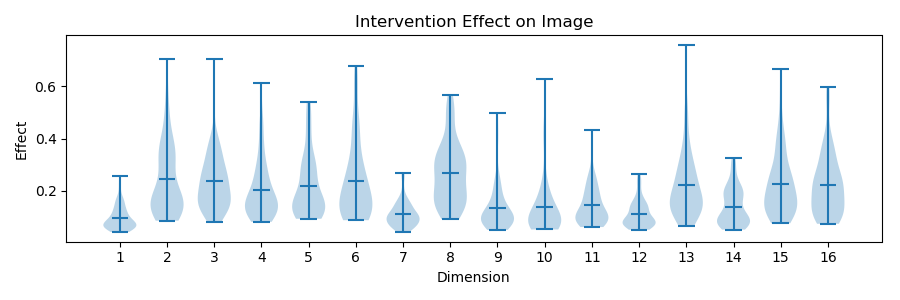

In [732]:
# violin plot of image effects
vals = all_diffs.cpu().numpy()
Xl = np.arange(vals.shape[-1])
fig, ax = plt.subplots(figsize=(9,3))
plt.violinplot(vals, Xl, points=200, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)
plt.xticks(Xl, map(str, Xl+1))
plt.title('Intervention Effect on Image')
plt.xlabel('Dimension')
plt.ylabel('Effect')
plt.tight_layout()
pass

In [733]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'effect.png'))

In [ ]:
layer = model.gen.fc[0].weight.clone().detach()
layer.shape

<IPython.core.display.Javascript object>


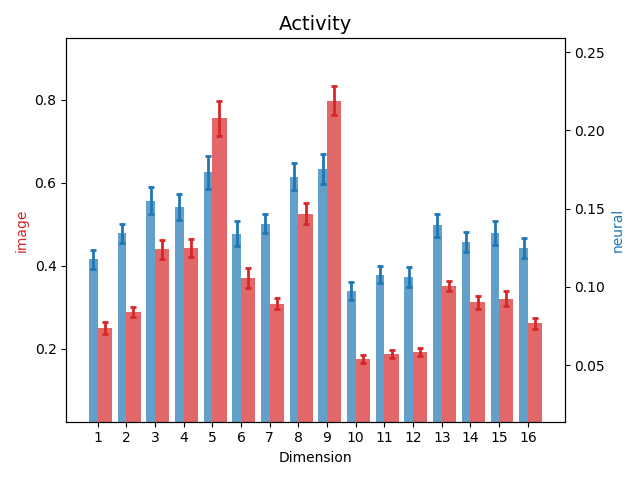

In [238]:
stats = [layer.abs(), all_diffs]
statns = ['neural', 'image']

fig, ax = plt.subplots()
plt.sca(ax)
wd = 0.3
emph = .2
plt.title("Activity", fontsize=14)
plt.xlabel('Dimension')
for i, (stat, sname) in enumerate(zip(stats, statns)):
    if i == 1:
        ax = ax.twinx()
    i = 1 - i
    stat = stats[i]
    sname = statns[i]
    plt.sca(ax)
    mu, sigma = stat.mean(0), stat.std(0)
    N = len(stat)
    X = np.arange(len(mu))
    color = 'C{}'.format(i*3)
    plt.ylabel(sname, color=color)
    plt.ylim(max(0,(mu.min()-sigma.mean()).cpu().numpy()), (mu.max()+sigma.mean()).cpu().numpy(), )
    plt.xticks(X, map(str, X+1))
    plt.bar(X+i*wd-wd/2+i*emph/2,mu.cpu().numpy(),wd+i*emph, color=color, alpha=0.7,
           yerr=sigma.cpu().numpy()/np.sqrt(N), error_kw=dict(ecolor=color, lw=2, capsize=2, capthick=2))
#     break
plt.tight_layout()
pass

In [239]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'activity.png'))

In [26]:
# plt.figure()
# # plt.imshow(rec[idx,0].cpu().numpy())
# plt.imshow(X[idx,0].cpu().numpy())
# plt.axis('off')

# vecs = torch.stack([q[idx]]*64)
# for i, dim in enumerate(dims):
#     dev = q[:,dim].std()
#     deltas = torch.linspace(q[:,dim].min()-dev, q[:,dim].max()+dev, 8)
#     deltas = torch.stack([deltas]*8)
#     if i == 1:
#         deltas = deltas.view(-1)
#     else:
#         deltas = deltas.t().contiguous().view(-1)
    
#     vecs[:,dim] = deltas

# with torch.no_grad():
#     walks = model.decode(vecs)

# show_nums(walks)

In [27]:
# plt.savefig(os.path.join(media_root,'dim5_2d_slice_3.png'))

In [47]:
dims = [0,1]
dims = [3,4]
# dims = [10,25]
idx = 28

In [48]:
H, W = 64, 64
grids = torch.from_numpy(np.mgrid[0:1:H*1j,0:1:W*1j]).to(args.device)
mn, mx = q[:,dims].min(0)[0].view(-1,1,1), q[:,dims].max(0)[0].view(-1,1,1)
grids *= mx - mn
grids += mn

deltas = grids.view(2,-1)
vecs = torch.stack([q[idx]]*deltas.size(-1))
vecs[:,dims[0]] = deltas[0]
vecs[:,dims[1]] = deltas[1]

qr = q[idx,dims]
qr = (qr - mn.squeeze()) / (mx-mn).squeeze()
qr *= torch.tensor([H,W]).to(args.device)
qr = qr.long().cpu().numpy()

In [49]:
# plt.figure()
# plt.imshow(rec[idx,0].cpu().numpy())
# plt.axis('off')

<IPython.core.display.Javascript object>


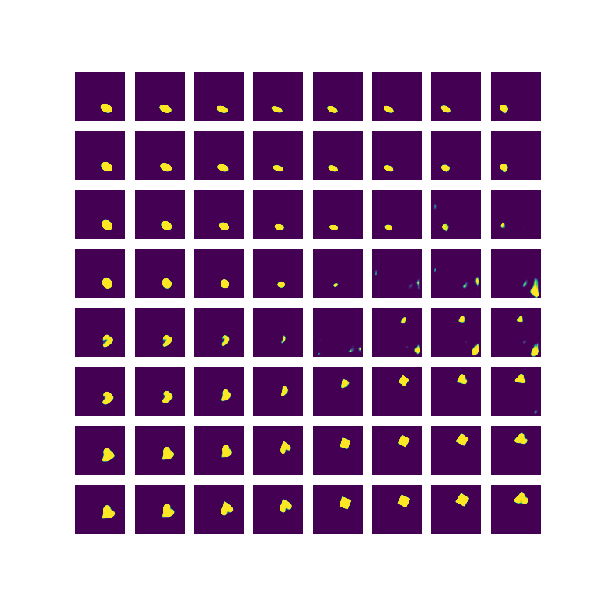

In [50]:
qimg = vecs.view(H,W,-1)[::8, ::8]
with torch.no_grad():
    imgs = model.decode(qimg)
show_nums(imgs)
pass

In [34]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'dims{}-{}-idx{idx}-recs.png'.format(*dims, idx=idx)))

<IPython.core.display.Javascript object>


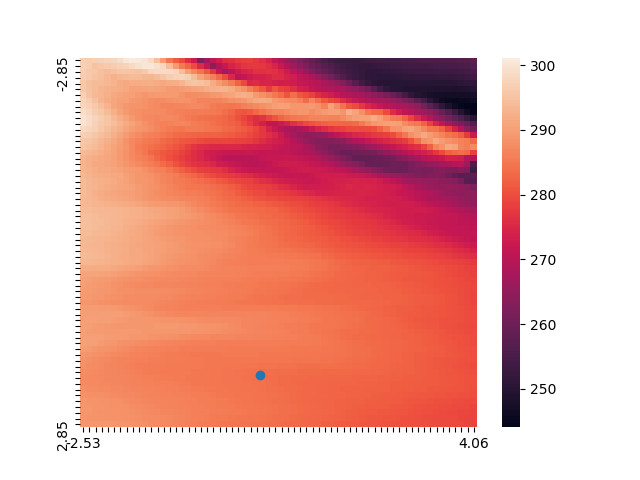

In [61]:
DL = DataLoader(TensorDataset(vecs), batch_size=128, shuffle=False)
verdicts = []
for v, in DL:
    with torch.no_grad():
        gens = model.decode(v)
        verdicts.append(model.disc(gens).detach())
verdicts = torch.cat(verdicts).view(H,W)
plt.figure()
ax = sns.heatmap(verdicts.cpu().numpy(), linewidth=0., 
                 xticklabels=['{:3.2f}'.format(mn[1].item())]+[None]*62 + ['{:3.2f}'.format(mx[1].item())],
                yticklabels=['{:3.2f}'.format(mn[0].item())]+[None]*62 + ['{:3.2f}'.format(mx[0].item())],)
# ax.set_xticks(np.linspace(mn[0].item(),mx[0].item(),H))
# ax.axis([mn[0].item(), mx[0].item(), mn[1].item(), mx[1].item()])

plt.scatter([qr[1].item()], [qr[0].item()])
plt.show()

In [57]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'dims{}-{}-idx{idx}-map.png'.format(*dims, idx=idx)))

<IPython.core.display.Javascript object>


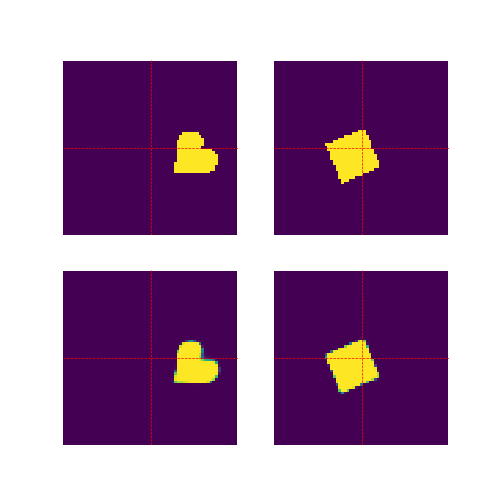

In [26]:
start_idx = 1
delta_idx = 0
mag = 1

layout = (3,6)

show_nums(torch.stack([X[start_idx], X[delta_idx],
           rec[start_idx], rec[delta_idx]]), figsize=(5,5), grdlines=True)
pass
# fig, (ax1,ax2) = plt.subplots(2)
# plt.sca(ax1)
# plt.imshow(rec[start_idx,0].cpu().numpy())
# plt.axis('off')
# plt.title('seed')
# plt.sca(ax2)
# plt.imshow(rec[delta_idx,0].cpu().numpy())
# plt.axis('off')
# plt.title('delta')

In [99]:
q[start_idx]

tensor([-0.1007,  0.0838,  0.2988,  0.1692,  0.6175, -0.1714, -0.1702, -0.6862,
         0.9353, -0.5450,  0.1462,  0.3704,  0.3490,  0.4187, -0.2287,  0.0151],
       device='cuda:0')

In [27]:
q[delta_idx]

tensor([-0.0580,  0.4725,  0.5292,  1.3166,  0.6064, -0.2938, -0.2960,  0.9958,
         0.0501,  0.4372, -1.4352,  0.3032,  0.2291,  0.1564, -0.4296, -0.2482],
       device='cuda:0')

In [28]:
start = q[[start_idx]]

In [29]:
D = start.size(-1)
mask = torch.ones(D,D,device=start.device)
mask1 = torch.tril(mask)
mask2 = torch.from_numpy(mask1.cpu().numpy()[:,::-1].copy()).to(start.device)
I = torch.eye(D,device=start.device)

z = torch.zeros_like(start)
mask1 = torch.cat([z,mask1])
mask2 = torch.cat([z,mask2])

mask = mask1
# mask = mask2
# mask = I
mask.shape

torch.Size([17, 16])

In [32]:
deltas = q[[delta_idx]] * mask
itv = start*(1-mask) + deltas
itv = itv.view(-1, start.size(-1))
# with torch.no_grad():
#     gitv = model.decode(itv)
#     vitv = model.disc(gitv)
# start.shape, deltas.shape, itv.shape

<IPython.core.display.Javascript object>


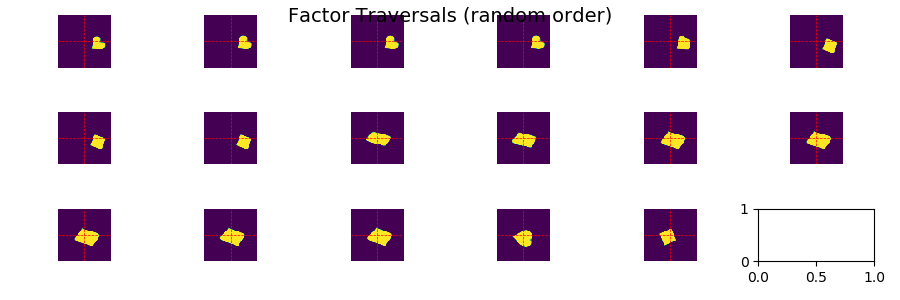

torch.Size([17, 1, 64, 64])

In [35]:
# titles = ['{:4.0f}'.format(v.item()) for v in vitv]
# titles = ['{:4.0f}'.format(v) for v in range(len(vitv))]
titles = None
fig = show_nums(gitv, titles=titles, H=layout[0], W=layout[1], figsize=(9,3), grdlines=True)
fig.suptitle("Factor Traversals (random order)", fontsize=14)
plt.tight_layout()
gitv.shape#, vitv.shape

In [156]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'idx{}-{}-factor-random.png'.format(start_idx, delta_idx)))

<IPython.core.display.Javascript object>


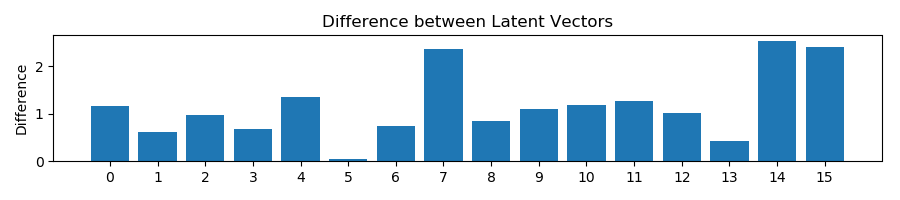

In [36]:
diffs = (q[delta_idx] - start.squeeze()).abs()
plt.figure(figsize=(9,2))
plt.bar(np.arange(0,D), diffs.cpu().numpy())
plt.xticks(np.arange(0,D),map(str,np.arange(0,D)))
plt.ylabel('Difference')
plt.title('Difference between Latent Vectors')
plt.tight_layout()

In [158]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'idx{}-{}-factor-diff.png'.format(start_idx, delta_idx)))

<IPython.core.display.Javascript object>


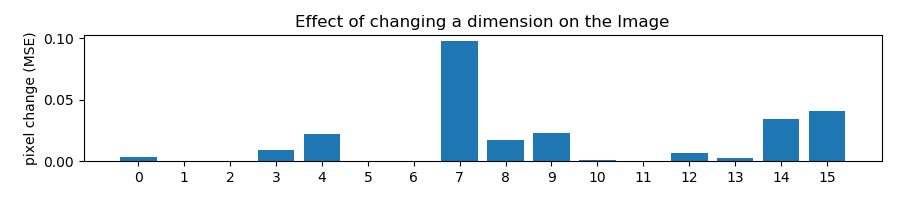

In [37]:
idiffs = (gitv[1:] - gitv[:-1]).pow(2).view(D,-1).mean(-1)
plt.figure(figsize=(9,2))
plt.bar(np.arange(0,D),idiffs.cpu().numpy())
plt.xticks(np.arange(0,D),map(str,np.arange(0,D)))
plt.ylabel('pixel change (MSE)')
plt.title('Effect of changing a dimension on the Image')
plt.tight_layout()

In [160]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'idx{}-{}-factor-imgdiff.png'.format(start_idx, delta_idx)))

In [38]:
inds = torch.arange(0,D,device=start.device)[idiffs>0.01]
print(len(inds), inds.cpu().numpy())

6 [ 4  7  8  9 14 15]


In [39]:
nosel = torch.ones(D,device=start.device,dtype=bool)
nosel[inds] = 0
ainds = torch.arange(D,device=start.device)[nosel].cpu().numpy()
inds = inds.cpu().numpy()
np.random.shuffle(inds)
np.random.shuffle(ainds)
inds, ainds = torch.from_numpy(inds).to(start.device), torch.from_numpy(ainds).to(start.device)
print(len(inds), inds.cpu().numpy())
print(len(ainds), ainds.cpu().numpy())

6 [15  7  8  4 14  9]
10 [10 12  2  3 13  6  1  0  5 11]


In [40]:
order = [ainds, inds]
order = [inds, ainds]
order = torch.cat(order)
# order = torch.argsort(idiffs, descending=True)
imask = torch.zeros_like(mask)
for n,i in enumerate(order):
    imask[n+1:,i] = 1
imask.shape

torch.Size([17, 16])

<IPython.core.display.Javascript object>


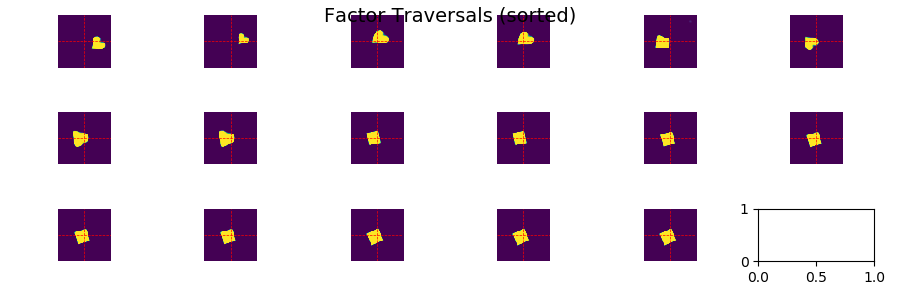

torch.Size([17, 1, 64, 64])

In [42]:
deltas = q[[delta_idx]] * imask
imp = start*(1-imask) + deltas
imp = imp.view(-1, start.size(-1))
with torch.no_grad():
    gimp = model.decode(imp)
#     vimp = model.disc(gimp)
    
# titles = ['{:4.0f}'.format(v.item()) for v in vimp]
# titles = ['{:4.0f}'.format(v) for v in range(len(vimp))]
titles = None
fig = show_nums(gimp, titles=titles, H=layout[0], W=layout[1], figsize=(9,3), grdlines=True)
fig.suptitle("Factor Traversals (sorted)", fontsize=14)
plt.tight_layout()
gimp.shape#, vimp.shape

In [165]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'idx{}-{}-factor-sorted.png'.format(start_idx, delta_idx)))

<IPython.core.display.Javascript object>


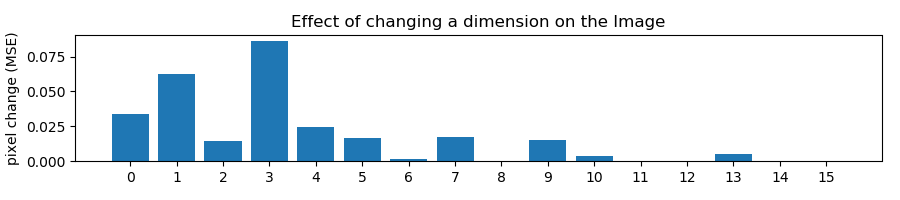

In [43]:
iimps = (gimp[1:] - gimp[:-1]).pow(2).view(D,-1).mean(-1)
plt.figure(figsize=(9,2))
plt.bar(np.arange(0,D),iimps.cpu().numpy())
plt.xticks(np.arange(0,D),map(str,np.arange(0,D)))
plt.ylabel('pixel change (MSE)')
plt.title('Effect of changing a dimension on the Image')
plt.tight_layout()

In [146]:
if save_figs:
    plt.savefig(os.path.join(save_dir,'idx{}-{}-factor-sorted-imgdiff.png'.format(start_idx, delta_idx)))